In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f, t
%matplotlib inline

# Распределение Уишарта и статистика Хотеллинга.
## Фахртдинов Тимур

# Задача

Исследовать наборы переменных (зависимая и независимые) на предмет наличия выбросов. Сравнить по совокупностям переменных мальчиков и девочек.

О наборе данных:<br>
Данные о недоношенных младенцах, у которых вовремя не закрылся артериальный проток.

Рассмотрим переменные:<br>
**Duration in hosp** -- Длительность госпитализации. <br> 
**O2 1** -- Насыщение крови кислородом до.<br>
**O2 2** -- Насыщение крови кислородом после.<br>
**PA1** -- Артериальное давление до.<br>
**PA2** -- Артериальное давление после.<br>
**Diuresis1** -- Диурез до.

In [2]:
data = pd.read_csv('baseMA.csv', sep=';', index_col=0)

data.head()

,therapy,Sex,Weight1,G age,Duration in hosp,Duration of Reanimation,Alone Breathing,Duration of Ventilation1,Duration of Ventilation2,O2 1,...,Age in Operation,Duration of Operation,CLOSE,BLD,RN,IVB,IVB_step,NEC,Day_of_clos,Outcome
1,3,1,980.0,27,82.0,36.0,NaN,NaN,NaN,0.25,...,NaN,NaN,1.0,1.0,1.0,1.0,2.0,0.0,0.0,1.0
2,3,1,1930.0,32,44.0,8.0,NaN,NaN,NaN,0.45,...,NaN,NaN,1.0,1.0,0.0,1.0,1.0,0.0,9.0,1.0
3,3,2,1090.0,28,51.0,8.0,NaN,NaN,NaN,0.21,...,NaN,NaN,1.0,0.0,1.0,0.0,0.0,0.0,6.0,1.0
4,2,1,1220.0,30,61.0,32.0,NaN,NaN,NaN,0.45,...,11.0,30.0,0.0,1.0,0.0,0.0,0.0,0.0,11.0,1.0
5,3,2,914.0,28,96.0,21.0,NaN,NaN,NaN,0.25,...,NaN,NaN,1.0,1.0,2.0,0.0,0.0,0.0,7.0,1.0


In [3]:
depend_var = ['Sex', 'O2 1', 'O2 2 ', 'PA1', 'PA2', 'Duration in hosp', 'Diuresis1']
data = data[depend_var]

data.head()

,Sex,O2 1,O2 2,PA1,PA2,Duration in hosp,Diuresis1
1,1,0.25,0.30,45.0,53.0,82.0,4.43
2,1,0.45,0.21,47.0,43.0,44.0,8.00
3,2,0.21,0.21,35.0,NaN,51.0,5.90
4,1,0.45,0.35,NaN,41.0,61.0,5.60
5,2,0.25,0.30,40.0,77.0,96.0,7.50


Исключим объекты, для которых есть пропущенные данные.

In [46]:
data = data.dropna()
data.head()

,Sex,O2 1,O2 2,PA1,PA2,Duration in hosp,Diuresis1
1,1,0.25,0.30,45.0,53.0,82.0,4.43
2,1,0.45,0.21,47.0,43.0,44.0,8.00
5,2,0.25,0.30,40.0,77.0,96.0,7.50
6,2,0.25,0.21,53.0,57.0,96.0,6.46
7,2,0.30,0.21,66.0,63.0,26.0,4.03


### Гипотезы о средних

Для мальчиков и девочек проверим гипотезу о равенстве нулю вектора средних для разности показателей до лечения и после лечения. Начнем с постоения boxplot'ов.

Для мальчиков:

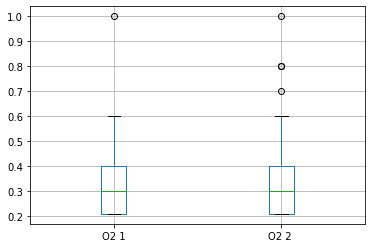

In [51]:
data.loc[data['Sex'] == 1].boxplot(column=['O2 1', 'O2 2 '])

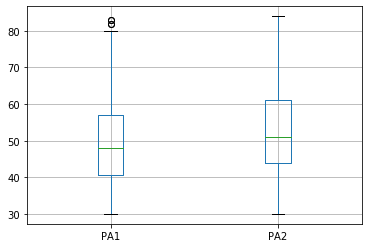

In [52]:
data.loc[data['Sex'] == 1].boxplot(column=['PA1', 'PA2'])

Для девочек:

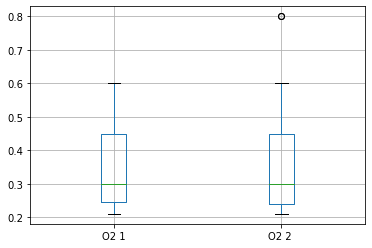

In [53]:
data.loc[data['Sex'] == 2].boxplot(column=['O2 1', 'O2 2 '])

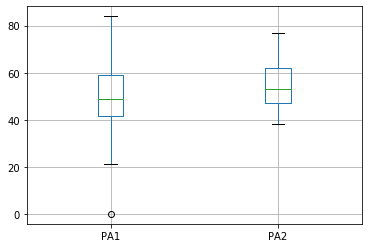

In [54]:
data.loc[data['Sex'] == 2].boxplot(column=['PA1', 'PA2'])

In [5]:
X_boys = data.loc[data['Sex'] == 1].iloc[:, 1:]
X_girls = data.loc[data['Sex'] == 2].iloc[:, 1:]

Используем для этого статистику $T^2_p$:<br>
$$T^2_p = N(\bar X - \mu)^T\hat \Sigma^{-1}(\bar X - \mu)$$
Известно, что:
$$\frac{N - p}{p(N - 1)} T^2_p \sim F(p, N - p) \$$

In [6]:
def T2(X, mu):
    means = X.mean(0)
    temp = X.mean(0) - mu
    temp = temp.reshape(temp.shape[0], 1)
    Sigma = np.cov(X, rowvar=False)
    T2 = temp.T.dot(np.linalg.inv(Sigma)).dot(temp)
    return X.shape[0] * T2.item()

In [7]:
def T2_stat(data, mu):
    X = data.to_numpy()
    stat = (X.shape[0] - X.shape[1]) * T2(X, mu) / (X.shape[1] * (X.shape[0] - 1))
    p_val = f.sf(stat, X.shape[1], X.shape[0] - X.shape[1])
    return stat, p_val

In [8]:
X_boys_dif = X_boys.copy()
X_girls_dif = X_girls.copy()

X_boys_dif['O2 dif'] = X_boys_dif['O2 2 '] - X_boys_dif['O2 1']
X_girls_dif['O2 dif'] = X_girls_dif['O2 2 '] - X_girls_dif['O2 1']

X_boys_dif['PA dif'] = X_boys_dif['PA2'] - X_boys_dif['PA1']
X_girls_dif['PA dif'] = X_girls_dif['PA2'] - X_girls_dif['PA1']

In [9]:
boys_stat, boys_p_value = T2_stat(X_boys_dif[['O2 dif', 'PA dif']], np.array([0, 0]))
print('Значение критерия {}, p-value {}'.format(round(boys_stat, 4), boys_p_value))

Значение критерия 2.297, p-value 0.10699978442222875


*p-value* > 0.05, нулевая гипотеза  о равенстве средних 0 у мальчиков не отвергается.

In [10]:
girls_stat, girls_p_value = T2_stat(X_girls_dif[['O2 dif', 'PA dif']], np.array([0, 0]))
print('Значение критерия {}, p-value {}'.format(round(girls_stat, 4), girls_p_value))

Значение критерия 1.387, p-value 0.2683957873237283


*p-value* > 0.05, нулевая гипотеза  о равенстве средних 0 у девочек не отвергается.

Проверим гипотезу $H_0: \mu_1 = \mu_2$, для средних значений мальчиков и девочек.

Используем для этого статистику Махаланобиса $D^2_p$
$$D^2_p = (\bar X_1 - \bar X_2)^T\hat \Sigma^{-1}(\bar X_1 - \bar X_2)$$ <br>
$$\frac{(N_1 + N_2 - p - 1)N_1N_2}{(N_1 + N_2 - 2)(N_1 + N_2)p}D^2 \sim F(p, N_1 + N_2 - p - 1)$$

In [11]:
def D2(data1, data2):
    mean1 = data1.mean(0)
    mean2 = data2.mean(0)
    d = mean1 - mean2
    d = d.reshape(d.shape[0], 1)
    
    Sigma1 = np.cov(data1, rowvar=False) * (data1.shape[0] - 1)
    Sigma2 = np.cov(data2, rowvar=False) * (data2.shape[0] - 1)
    Sigma = (Sigma1 + Sigma2) / (data1.shape[0] + data2.shape[0] - 2)
    
    return d.T.dot(np.linalg.inv(Sigma)).dot(d).item() 

In [12]:
def D2_stat(data1, data2):
    X1 = data1.to_numpy()
    X2 = data2.to_numpy()
    N1 = X1.shape[0]
    N2 = X2.shape[0]
    p = X1.shape[1]
    d2 = D2(X1, X2)
    stat = (N1 + N2 - p - 1) * N1 * N2 * d2 / (p * (N1 + N2) * (N1 + N2 - 2))
    p_val = f.sf(stat, p, N1 + N2 - p - 1)
    return stat, p_val

In [13]:
stat, p_val = D2_stat(X_boys, X_girls)
print('Значение критерия {}, p-value {}'.format(stat, p_val))

Значение критерия 0.11634014836186712, p-value 0.9942948584243724


*p-value* > 0.05, нет оснований отклонить нулевую гипотезу.

### Выбросы.

Чтобы проверить имеются ли в выборке выбросы для каждого $x_i$, $i = 0, \ldots, n$, по всем $N = n - 1$ векторам наблюдений, исключая $x_i$, вычисляются $\bar x_i$, ковариционная матрица $\hat \Sigma_i$ и расстояние Махаланобиса $D^2_i$ между $x_i$ и $\bar x_i$ и соответствующие *p-value* $p_i$.

Расстояние Махаланобиса:
$$D^2_p = (x - \hat x)^T\hat \Sigma^{-1}(x - \hat x)$$ <br>
$$\frac{(N - p)N}{(N^2 - 1)p}D^2 \sim F(p, N - p)$$

In [14]:
def outlier(x, data):
    means = data.mean(0)
    d = x - means
    d = d.reshape(d.shape[0], 1)
    Sigma = np.cov(data, rowvar=False)
    return d.T.dot(np.linalg.inv(Sigma)).dot(d).item() 

In [35]:
def outlier_stat(data):
    X = data.to_numpy()
    p_val = np.array(list())
    d2 = np.array(list())
    N = X.shape[0]
    p = X.shape[1]
    for i in range(X.shape[0]):
        X_i = np.delete(X, i, axis=0)
        D2_i = outlier(X[i], X_i)
        temp = (N - p) * N * D2_i / ((N**2 - 1) * p)
        d2 = np.append(d2, D2_i)
        p_val = np.append(p_val, f.sf(temp, X.shape[1], X.shape[0] - X.shape[1]))
    
    data['D2'] = d2
    data['p-value'] = p_val

Разделим данные и нарисуем графики, отметив на них выбросы:

In [37]:
X_boys = data.loc[data['Sex'] == 1].iloc[:, 1:]
X_girls = data.loc[data['Sex'] == 2].iloc[:, 1:]

In [38]:
outlier_stat(X_girls)
outlier_stat(X_boys)

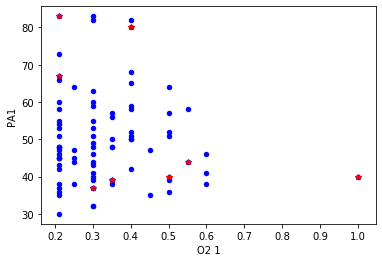

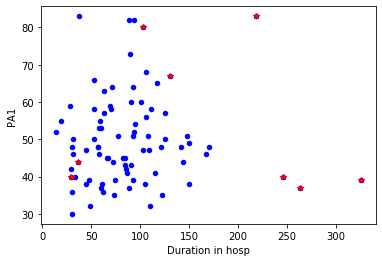

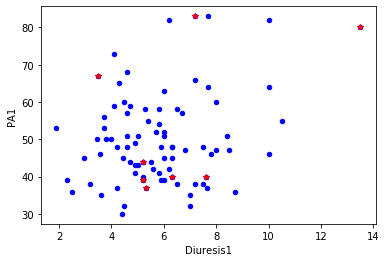

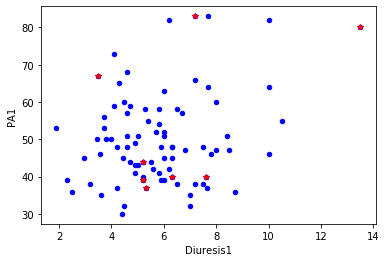

In [39]:
X_boys.plot(y='PA1', x='O2 1', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['O2 1'], X_boys[X_boys['p-value'] < 0.05]['PA1'], 'r*')

X_boys.plot(y='PA1', x='Duration in hosp', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['Duration in hosp'], X_boys[X_boys['p-value'] < 0.05]['PA1'], 'r*')

X_boys.plot(y='PA1', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['Diuresis1'], X_boys[X_boys['p-value'] < 0.05]['PA1'], 'r*')

X_boys.plot(y='PA1', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['Diuresis1'], X_boys[X_boys['p-value'] < 0.05]['PA1'], 'r*')

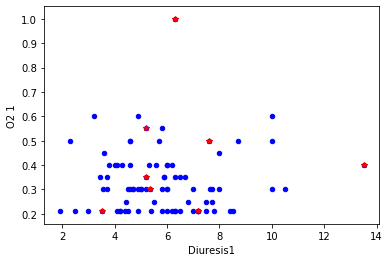

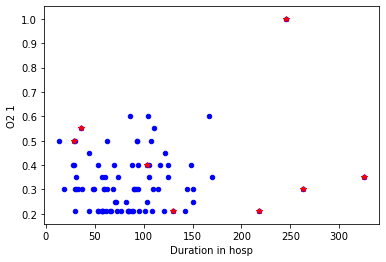

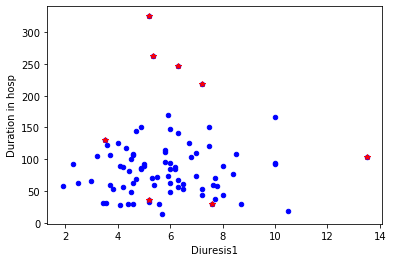

In [40]:
X_boys.plot(y='O2 1', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['Diuresis1'], X_boys[X_boys['p-value'] < 0.05]['O2 1'], 'r*')

X_boys.plot(y='O2 1', x='Duration in hosp', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['Duration in hosp'], X_boys[X_boys['p-value'] < 0.05]['O2 1'], 'r*')

X_boys.plot(y='Duration in hosp', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_boys[X_boys['p-value'] < 0.05]['Diuresis1'], X_boys[X_boys['p-value'] < 0.05]['Duration in hosp'], 'r*')

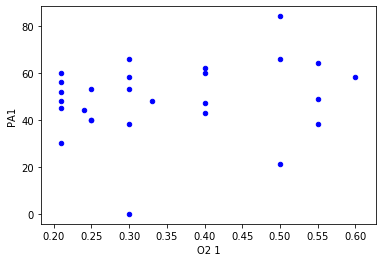

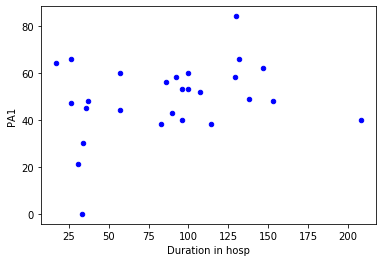

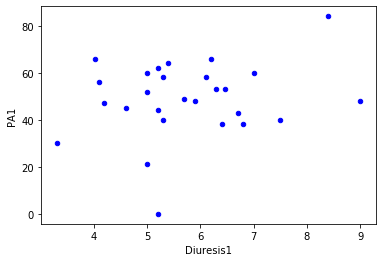

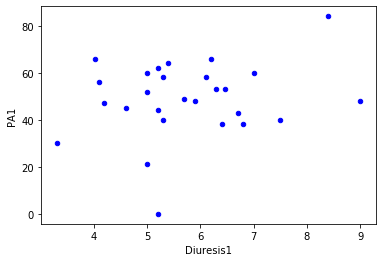

In [41]:
X_girls.plot(y='PA1', x='O2 1', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['O2 1'], X_girls[X_girls['p-value'] < 0.05]['PA1'], 'r*')

X_girls.plot(y='PA1', x='Duration in hosp', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['Duration in hosp'], X_girls[X_girls['p-value'] < 0.05]['PA1'], 'r*')

X_girls.plot(y='PA1', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['Diuresis1'], X_girls[X_girls['p-value'] < 0.05]['PA1'], 'r*')

X_girls.plot(y='PA1', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['Diuresis1'], X_girls[X_girls['p-value'] < 0.05]['PA1'], 'r*')

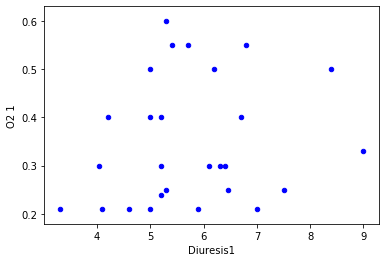

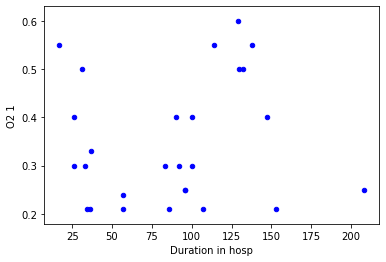

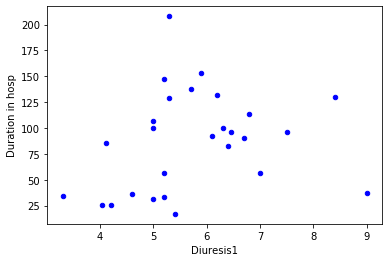

In [42]:
X_girls.plot(y='O2 1', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['Diuresis1'], X_girls[X_girls['p-value'] < 0.05]['O2 1'], 'r*')

X_girls.plot(y='O2 1', x='Duration in hosp', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['Duration in hosp'], X_girls[X_girls['p-value'] < 0.05]['O2 1'], 'r*')

X_girls.plot(y='Duration in hosp', x='Diuresis1', kind='scatter', color='blue')
plt.plot(X_girls[X_girls['p-value'] < 0.05]['Diuresis1'], X_girls[X_girls['p-value'] < 0.05]['Duration in hosp'], 'r*')